In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

dataset_path = 'archive/Aerial_Landscapes/'

def load_images_labels(dataset_path, image_size=(256, 256)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))  

    for label in class_names:
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            img = cv2.imread(file_path)
            if img is not None:
                images.append(img)
                labels.append(label)

    return images, labels


images, labels = load_images_labels(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=42)

print('success')


success


In [10]:
sift = cv2.SIFT_create()
all_descriptors = []

for img in X_train:
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
        des = des.astype(np.double)
        all_descriptors.extend(des)

print('success')

success


In [11]:
k = 200
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=2048)
kmeans.fit(all_descriptors)
print('success')

success


In [20]:
k1 = 100
kmeans1 = MiniBatchKMeans(n_clusters=k, batch_size=2048)
kmeans1.fit(all_descriptors)
print('success')

success


In [12]:
def extract_bow_features(images, sift, kmeans):
    features = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            des = des.astype(np.double)
            hist = np.zeros(k)
            words = kmeans.predict(des)
            for w in words:
                hist[w] += 1
            features.append(hist)
        else:
            features.append(np.zeros(k))  # fallback
    return np.array(features)

X_train_bow = extract_bow_features(X_train, sift, kmeans)
X_test_bow = extract_bow_features(X_test, sift, kmeans)

print('success')


success


In [22]:
X_train_bow1 = extract_bow_features(X_train, sift, kmeans1)
X_test_bow1 = extract_bow_features(X_test, sift, kmeans1)

print('success-X_train_bow1-keanms1_k1=100')

success-X_train_bow1-keanms1_k1=100


In [13]:
# 4. 标准化 + SVM 训练
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bow)
X_test_scaled = scaler.transform(X_test_bow)

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

print('success')


success


In [48]:

def svmtrain(X_train_bow, X_test_bow, kernell, C0):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bow)
    X_test_scaled = scaler.transform(X_test_bow)

    svm = SVC(kernel = kernell, C=C0, gamma='scale')
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)

    return y_pred

y_pred1 = svmtrain(X_train_bow1, X_test_bow1, 'rbf', 10)

print('success, kmean_k=100,kernel=rbf, C=10')

success, kmean_k=100,kernel=rbf, C=10


In [42]:
kernel_linear = 'linear'
y_predlinear_200 = svmtrain(X_train_bow, X_test_bow, kernel_linear, 10)
print('success, kmean_k=200,kernel=linear, C=10')

success, kmean_k=200,kernel=linear, C=10


In [52]:
C2 = 0.1
y_predrbfC2 = svmtrain(X_train_bow, X_test_bow, 'rbf', C2)

print('success, kmean_k=100,kernel=rbf, C=0.1')

success, kmean_k=100,kernel=rbf, C=0.1


In [86]:
def show_comparison_examples(images, y_true, y_pred, num=5):
    correct = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
    wrong = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    
    total = min(num, len(correct), len(wrong))
    plt.figure(figsize=(15, 4))

    for i in range(total):
        # 成功案例
        idx_c = correct[i]
        plt.subplot(2, total, i + 1)
        plt.imshow(cv2.cvtColor(images[idx_c], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {y_true[idx_c]}\nPred: {y_pred[idx_c]}", fontsize=10)
        plt.axis('off')

        # 失败案例
        idx_w = wrong[i]
        plt.subplot(2, total, total + i + 1)
        plt.imshow(cv2.cvtColor(images[idx_w], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {y_true[idx_w]}\nPred: {y_pred[idx_w]}", fontsize=10)
        plt.axis('off')

    plt.suptitle("Top Row: Correct • Bottom Row: Incorrect Predictions", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

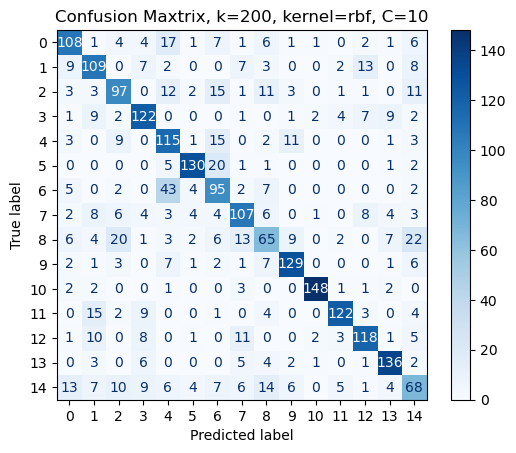

              precision    recall  f1-score   support

 Agriculture       0.70      0.68      0.69       160
     Airport       0.63      0.68      0.66       160
       Beach       0.63      0.61      0.62       160
        City       0.72      0.76      0.74       160
      Desert       0.54      0.72      0.61       160
      Forest       0.87      0.81      0.84       160
   Grassland       0.55      0.59      0.57       160
     Highway       0.67      0.67      0.67       160
        Lake       0.50      0.41      0.45       160
    Mountain       0.80      0.81      0.80       160
     Parking       0.95      0.93      0.94       160
        Port       0.87      0.76      0.81       160
     Railway       0.76      0.74      0.75       160
 Residential       0.81      0.85      0.83       160
       River       0.47      0.42      0.45       160

    accuracy                           0.70      2400
   macro avg       0.70      0.70      0.70      2400
weighted avg       0.70   

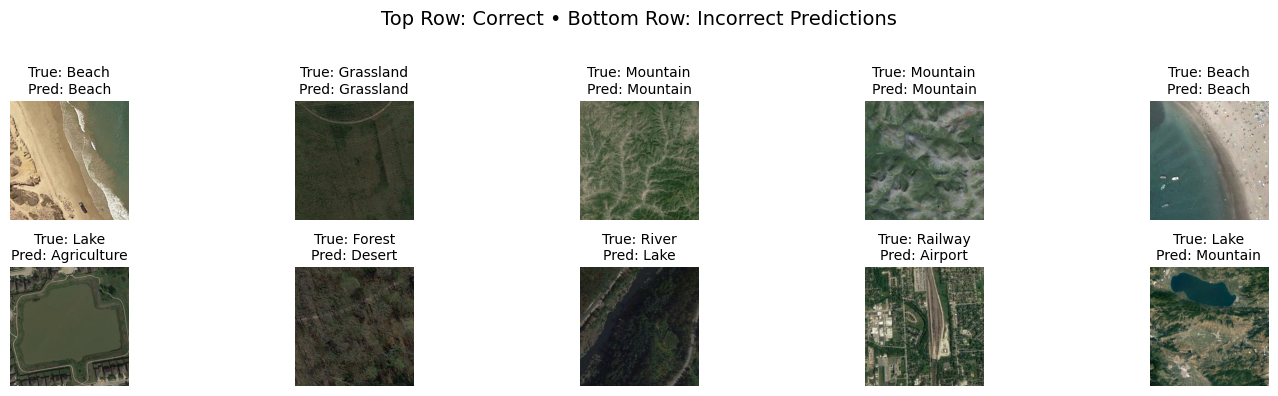

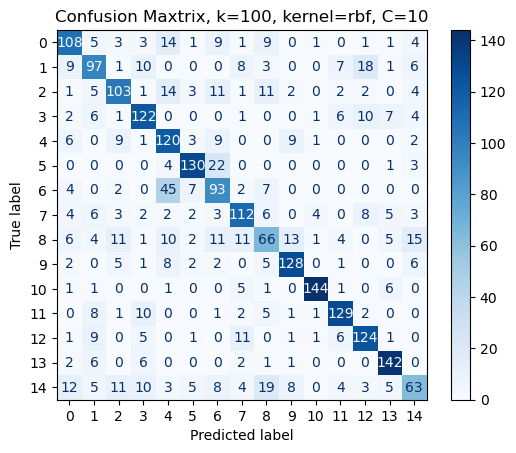

              precision    recall  f1-score   support

 Agriculture       0.68      0.68      0.68       160
     Airport       0.64      0.61      0.62       160
       Beach       0.69      0.64      0.66       160
        City       0.71      0.76      0.73       160
      Desert       0.54      0.75      0.63       160
      Forest       0.83      0.81      0.82       160
   Grassland       0.55      0.58      0.57       160
     Highway       0.70      0.70      0.70       160
        Lake       0.50      0.41      0.45       160
    Mountain       0.79      0.80      0.79       160
     Parking       0.94      0.90      0.92       160
        Port       0.81      0.81      0.81       160
     Railway       0.74      0.78      0.76       160
 Residential       0.82      0.89      0.85       160
       River       0.57      0.39      0.47       160

    accuracy                           0.70      2400
   macro avg       0.70      0.70      0.70      2400
weighted avg       0.70   

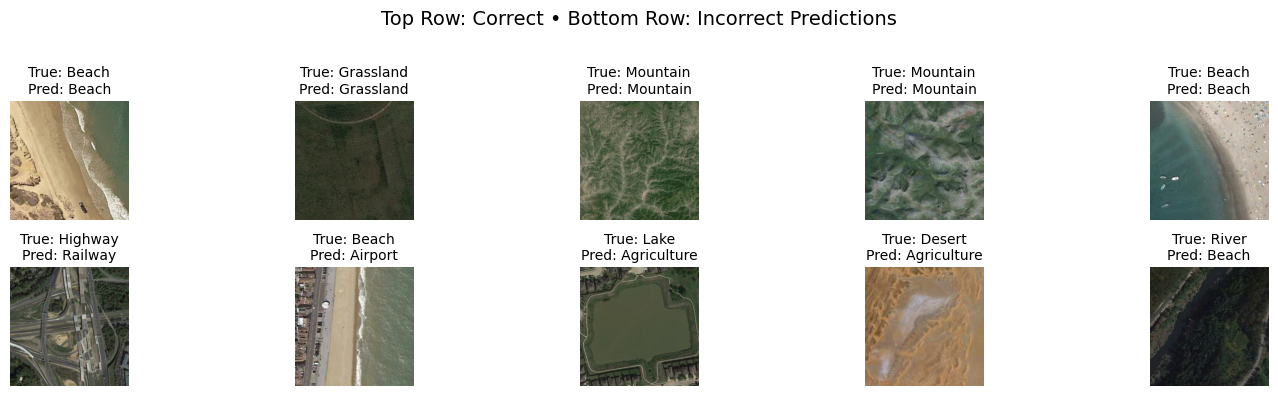

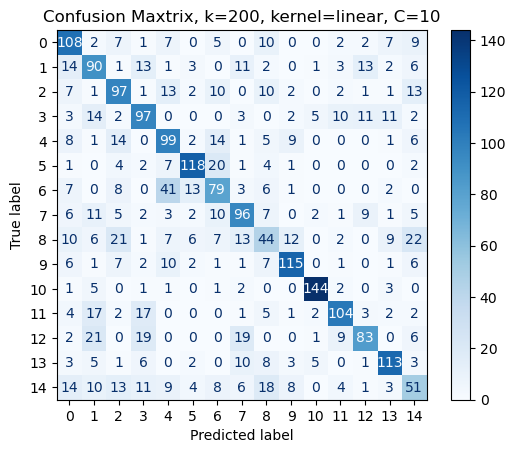

              precision    recall  f1-score   support

 Agriculture       0.56      0.68      0.61       160
     Airport       0.49      0.56      0.52       160
       Beach       0.53      0.61      0.57       160
        City       0.56      0.61      0.58       160
      Desert       0.50      0.62      0.55       160
      Forest       0.77      0.74      0.75       160
   Grassland       0.51      0.49      0.50       160
     Highway       0.57      0.60      0.59       160
        Lake       0.35      0.28      0.31       160
    Mountain       0.75      0.72      0.73       160
     Parking       0.90      0.90      0.90       160
        Port       0.74      0.65      0.69       160
     Railway       0.67      0.52      0.58       160
 Residential       0.72      0.71      0.72       160
       River       0.38      0.32      0.35       160

    accuracy                           0.60      2400
   macro avg       0.60      0.60      0.60      2400
weighted avg       0.60   

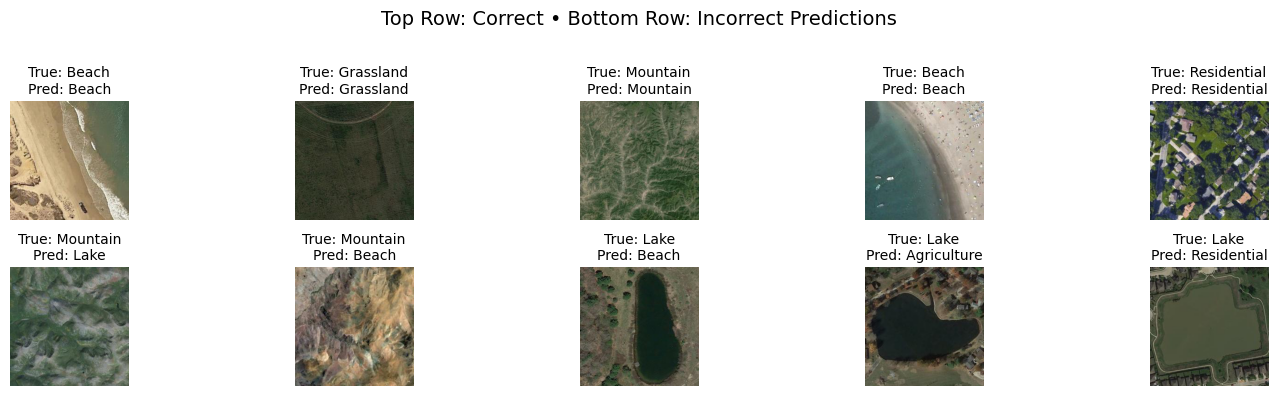

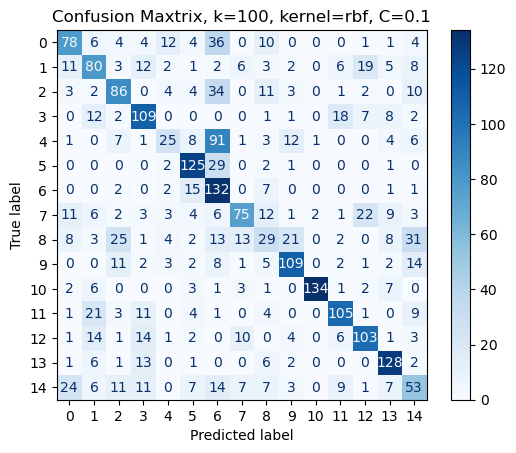

              precision    recall  f1-score   support

 Agriculture       0.55      0.49      0.52       160
     Airport       0.49      0.50      0.50       160
       Beach       0.54      0.54      0.54       160
        City       0.60      0.68      0.64       160
      Desert       0.43      0.16      0.23       160
      Forest       0.69      0.78      0.73       160
   Grassland       0.36      0.82      0.50       160
     Highway       0.65      0.47      0.54       160
        Lake       0.29      0.18      0.22       160
    Mountain       0.69      0.68      0.68       160
     Parking       0.98      0.84      0.90       160
        Port       0.70      0.66      0.68       160
     Railway       0.65      0.64      0.65       160
 Residential       0.70      0.80      0.75       160
       River       0.36      0.33      0.35       160

    accuracy                           0.57      2400
   macro avg       0.58      0.57      0.56      2400
weighted avg       0.58   

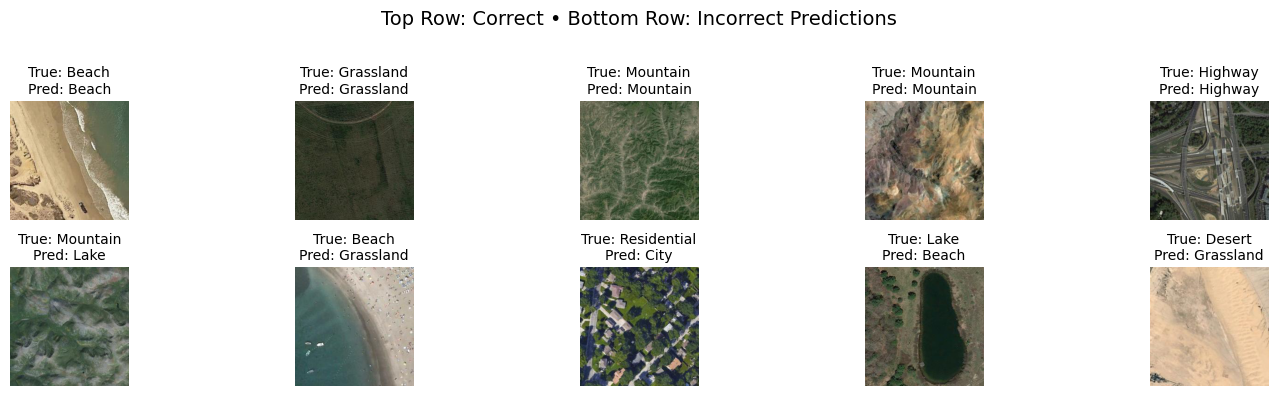

In [88]:
# 5. 评估
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def showresult(y_pred, k, kernel, C):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f'Confusion Maxtrix, k={k}, kernel={kernel}, C={C}')
    plt.show()
    print(classification_report(y_test, y_pred))
    show_comparison_examples(X_test, y_test, y_pred, num=5)

kernel = 'rbf'
C1 = 10
showresult(y_pred, k, kernel, C1)
showresult(y_pred1, k1,kernel, C1)
showresult(y_predlinear_200, k, kernel_linear, C1)
showresult(y_predrbfC2, k1,kernel, C2)
